### Example where low level evaluations are not composable ... e.g. if they are a PF with state

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
from HINTS import *
from HINTS_fn_simple import * # SIMPLIFIED USER FUNCTION - NO REUSE - GOOD FOR WRAPPING PARTICLE FILTER

%matplotlib inline
import matplotlib.pyplot as plt # just for testing

In [3]:
# NB the proposed state must not share memory with the original state (because we hash when we cache)
def proposal_alpha(state, index):
    return(state + 0.05 * randn(state.shape[0]), 0.0) # new state, optional evaluation at new state, correction for asymmetry  


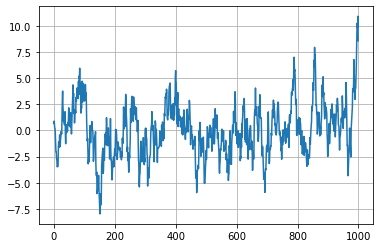

In [4]:
# test the user function

#e = TestFnSign(proposal1, xs.size)
N = 1000
TRUE_ALPHA = 0.1
e = TestFnIOU(proposal_alpha, N, alpha = TRUE_ALPHA)

# check the observations - this is the assumed dataset and so is fixed for a whole HINTS run
plt.plot(e.ys)
plt.grid()



Text(0.5, 0, 'alpha')

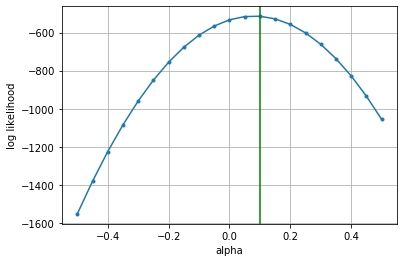

In [5]:
# check that we have a max of likelihood near the actual alpha:

alphas = np.arange(-0.5, 0.51, 0.05)
likes = np.array([e.evaluate_sequence(alpha, 0, N) for alpha in alphas])
plt.plot(alphas, likes, marker = '.')
plt.grid()
plt.axvline(TRUE_ALPHA, color = 'green')
plt.ylabel('log likelihood')
plt.xlabel('alpha')

In [6]:
# test that the evalauation
e.lockdown_randomness(1)
print(e.evaluate_sequence(0.2, 0, 10))
print(e.evaluate_sequence(0.2, 0, 10)) # should be same
e.lockdown_randomness(2)
print(e.evaluate_sequence(0.2, 0, 10)) # should be different


-2.0232006298014245
-2.0232006298014245
-2.080553579204045


In [7]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults

if True:
    args.levels = 2
    log_branch_factor = 2 # 2 means 4 branches per node, etc
    N_0 = 25
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    iterations = 5000
else: #MCMC (slower)
    args.levels = 0
    NUM_SCENARIOS = 400
    args.design = np.array([NUM_SCENARIOS])
    iterations = 5000# need to match actual evaluations

print(NUM_SCENARIOS)

# design now has levels + 1 entries

args.T = 1.0 #top level
args.dT = 0.0

print(args.__dict__)

400
{'levels': 2, 'design': array([25,  4,  4]), 'T': 1.0, 'dT': 0.0}


In [9]:
# CHOOSE YOUR OWN TEST FUNCTION HERE!

g = TestFnIOU(proposal_alpha, NUM_SCENARIOS, TRUE_ALPHA)
hpf = HINTS(args, g, shuffle_as_we_go = True) # shuffle as we go preserves ordering in leaves
state  = g.sample_initial_state() # only used once, for initialisation of the sampling chain

# histogram parameters for binning data
nsd = 0.50001 # for diagnostics only
bins = 64

histogram = np.zeros([bins], dtype = float)

#%timeit hmc.shuffle() # negligible
#%timeit hmc.hints(state,  levels, index = 0, T = 1.0, dbg = False) # e.g. dbg = (t==0)


RESET
2
[ 25 100 400]
400
[1. 1. 1.]


In [10]:
for t in range(iterations):
    #hpf.shuffle() # NO! do a more limited shuffle using shuffle-as-we-go
    hpf.fn.lockdown_randomness(t)
    state, _ = hpf.hints(state, args.levels) # e.g. dbg = (t==0)
    # diagnostic histogram
    if (abs(state[0]) < nsd): # ignoring samples outside diagnostic range
        j = round((state[0] + nsd) * bins/(2.0 * nsd))
        histogram[j] += 1.0
    # show progress
    if ((t%500)==499):
        print(t+1, hpf.acceptances, hpf.rejections)
        #print(cache.stats(enable=True, reset = True))


500 [6707 1082  286] [1293  918  214]
1000 [13336  2162   571] [2664 1838  429]
1500 [19990  3274   846] [4010 2726  654]
2000 [26648  4378  1112] [5352 3622  888]
2500 [33304  5431  1379] [6696 4569 1121]
3000 [39954  6504  1665] [8046 5496 1335]
3500 [46631  7643  1924] [9369 6357 1576]
4000 [53343  8722  2203] [10657  7278  1797]
4500 [60015  9806  2469] [11985  8194  2031]
5000 [66718 10868  2738] [13282  9132  2262]


In [11]:
print(hpf.acceptances)
print(hpf.rejections)
print(hpf.acceptances / (hpf.acceptances + hpf.rejections))

[66718 10868  2738]
[13282  9132  2262]
[0.833975 0.5434   0.5476  ]


400


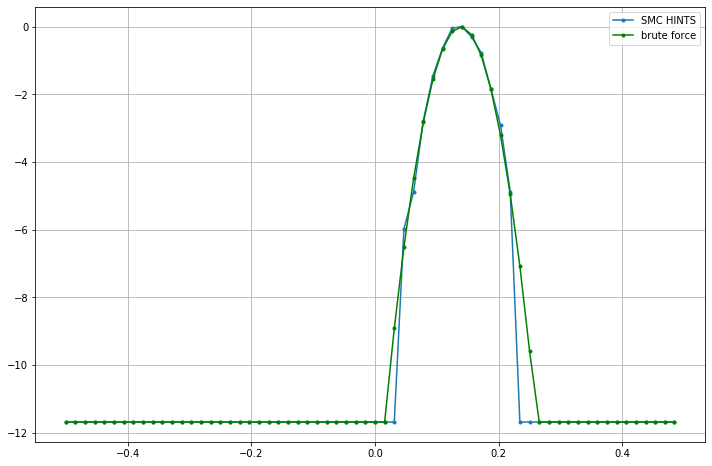

In [13]:
#plt.plot(histogram)
fig = plt.figure(figsize=[12,8])
ax1 = plt.gca()
xs1 = np.arange(bins, dtype = float) * (2.0 * nsd)/bins - nsd 

logprob = np.log(histogram + 0.01)
logprob -= np.max(logprob)

plt.plot(xs1, logprob, marker = '.', label = 'SMC HINTS')
plt.grid()

# also plot true log prob from exhaustive eval
print(NUM_SCENARIOS)
likes = np.array([g.evaluate_sequence(alpha, 0, NUM_SCENARIOS) for alpha in xs1])
likes -= np.max(likes)
plt.gca().plot(xs1, np.clip(likes, a_min = np.min(logprob), a_max = 0.0),   color = 'green', marker = '.', label = 'brute force')
plt.legend()

